In [1]:
from multiprocessing import Pool
from keras.utils import load_img, img_to_array 
import glob
import numpy as np
from tqdm import tqdm

# First Time (train-test split)

In [2]:
def noise(array, noise_factor=1, mean=0, std=1):
    """
    Adds random noise to each image in the supplied array.
    """
    noisy_array = array + noise_factor * np.random.normal(
        mean, std, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

import matplotlib.pyplot as plt

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def display_test(array1, array2, array3):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    

    plt.figure(figsize=(20, 4))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(image3)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
# face_images = glob.glob('../DATA/thumbnails128x128/*.png')

# def read(path):
#     img = load_img(path)
#     img = img_to_array(img)
#     img = img/255.
#     return img

# img_array = []
# for path in tqdm(face_images[:20000]):
#     img = read(path)
#     img_array.append(img)

In [ ]:
# train_data = np.array(img_array)
# noisy_train_data = noise(train_data, 1, 0, 0.2)

# display(train_data, noisy_train_data)

In [ ]:
# # save the train data and noisy train data
# import pickle

# with open('../DATA/thumbnails128x128/train_data.pkl', 'wb') as f:
#     pickle.dump(train_data, f)

# with open('../DATA/thumbnails128x128/noisy_train_data.pkl', 'wb') as f:
#     pickle.dump(noisy_train_data, f)

In [ ]:
# face_images = glob.glob('../DATA/thumbnails128x128/*.png')

# def read(path):
#     img = load_img(path)
#     img = img_to_array(img)
#     img = img/255.
#     return img

# img_array = []
# for path in tqdm(face_images[20000:22000]):
#     img = read(path)
#     img_array.append(img)

# test_data = np.array(img_array)
# noisy_test_data = noise(test_data, 1, 0, 0.2)

# display(test_data, noisy_test_data)



In [ ]:
# # save the test data and noisy test data
# import pickle

# with open('../DATA/thumbnails128x128/test_data.pkl', 'wb') as f:
#     pickle.dump(test_data, f)

# with open('../DATA/thumbnails128x128/noisy_test_data.pkl', 'wb') as f:
#     pickle.dump(noisy_test_data, f)

# Load train data

In [3]:
import pickle
with open('../DATA/thumbnails128x128/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

print(train_data.shape)

with open('../DATA/thumbnails128x128/noisy_train_data.pkl', 'rb') as f:
    noisy_train_data = pickle.load(f)

print(noisy_train_data.shape)

(20000, 128, 128, 3)
(20000, 128, 128, 3)


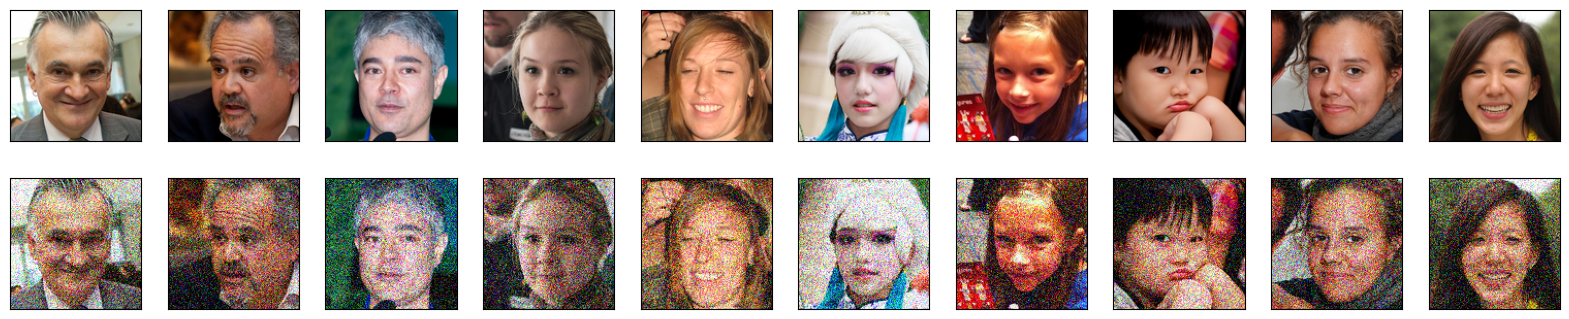

In [4]:
display(train_data, noisy_train_data)

# Model Training

In [5]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from AE_RESNET.resnetAE import ResNetAE
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [9]:
resnet50AE = ResNetAE(input_shape = (128, 128, 3), output_channels=3,
                      bottleneck_layers=[3,4,6,3],bottleneck_strides=[1,2,2,2], 
                      bottleneck_num_layer=3)
resnet50AE.summary()

Model: "ResNetAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 ResNet_encoder (Functional)  (None, 4, 4, 2048)       23587712  
                                                                 
 ResNet_decoder (Functional)  (None, 128, 128, 3)      28838031  
                                                                 
Total params: 52,425,743
Trainable params: 52,319,625
Non-trainable params: 106,118
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet50AE.compile(optimizer=optimizer, loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = resnet50AE.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=30,
    batch_size=16,
    shuffle=True,
    validation_data=None,
    validation_split=0.1,
    callbacks=[early_stopping],
)

Epoch 1/30
1125/1125 [==============================] - 199s 168ms/step - loss: 0.0240 - val_loss: 0.0169
Epoch 2/30
1125/1125 [==============================] - 188s 167ms/step - loss: 0.0137 - val_loss: 0.0109
Epoch 3/30
1125/1125 [==============================] - 188s 167ms/step - loss: 0.0108 - val_loss: 0.0096
Epoch 4/30
1125/1125 [==============================] - 188s 167ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 5/30
1125/1125 [==============================] - 188s 167ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 6/30
1125/1125 [==============================] - 188s 167ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 7/30
1125/1125 [==============================] - 188s 167ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/30
1125/1125 [==============================] - 188s 167ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 9/30
1125/1125 [==============================] - 188s 167ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 10/30
1125/1125 [=======================

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lr(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

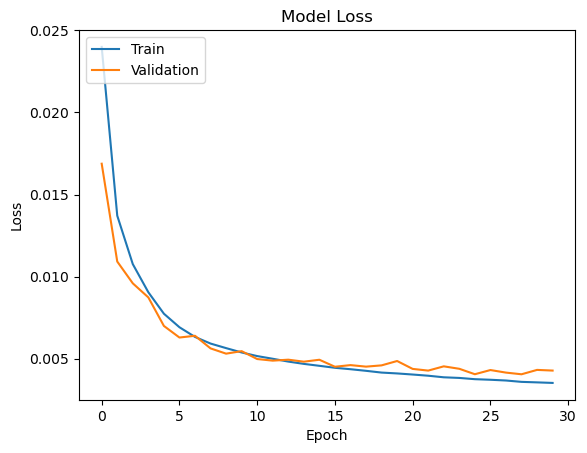

In [12]:
plot_lr(history)

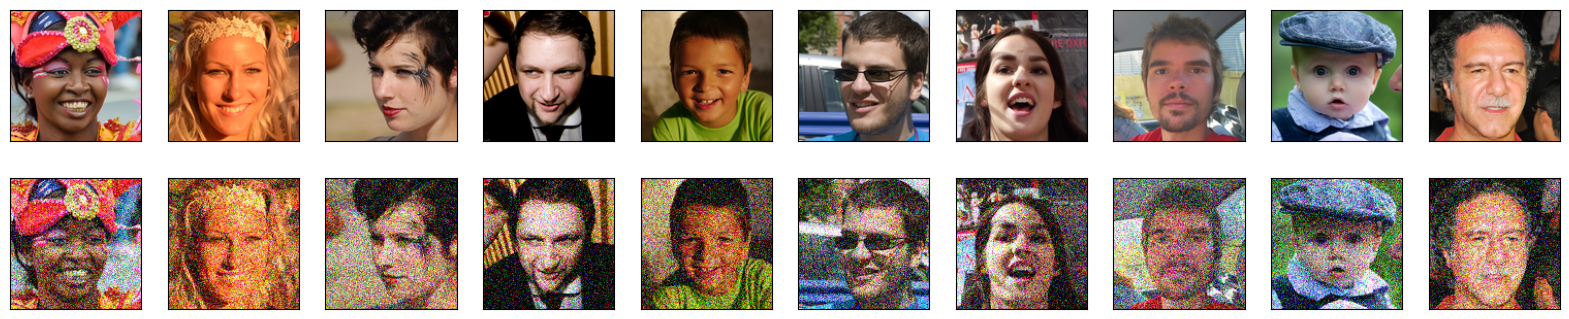

In [13]:
# load the test data

with open('../DATA/thumbnails128x128/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('../DATA/thumbnails128x128/noisy_test_data.pkl', 'rb') as f:
    noisy_test_data = pickle.load(f)

display(test_data, noisy_test_data)

63/63 [==============================] - 10s 99ms/step


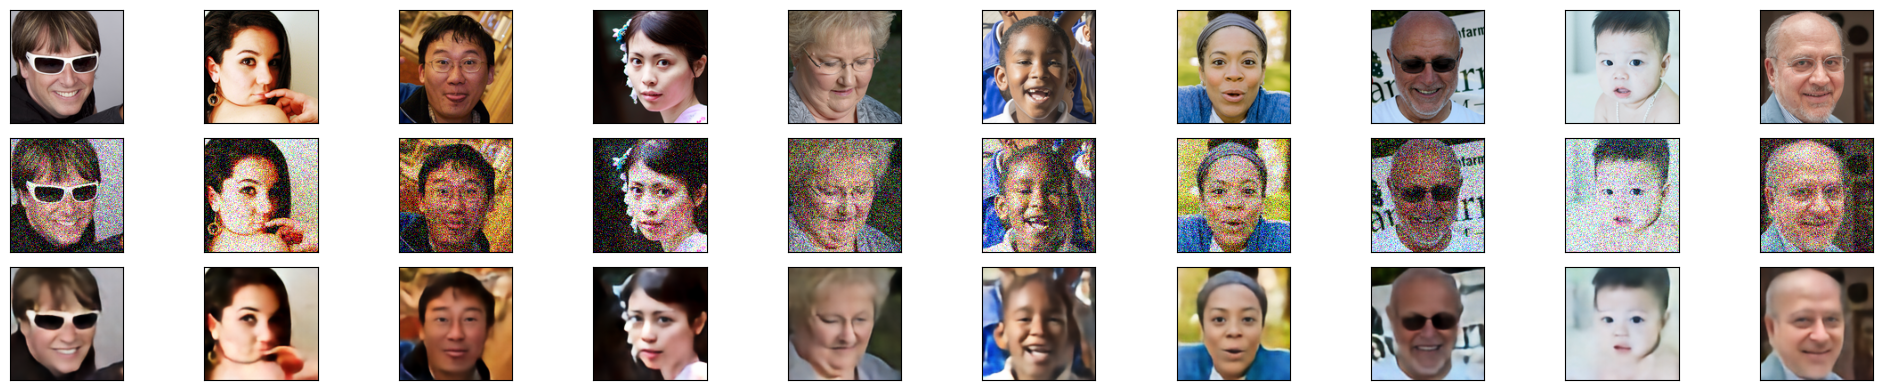

In [14]:
predicted_test_data = resnet50AE.predict(noisy_test_data)

display_test(test_data, noisy_test_data, predicted_test_data)

In [15]:
# ssim score
test_data = tf.cast(test_data, tf.float32)
predicted_test_data = tf.cast(predicted_test_data, tf.float32)
noisy_test_data = tf.cast(noisy_test_data, tf.float32)

ssim = tf.image.ssim(test_data, predicted_test_data, max_val=1.0)
ssim = tf.reduce_mean(ssim)
print('SSIM Score:',ssim)

ssim2 = tf.image.ssim(test_data, noisy_test_data, max_val=1.0)
ssim2 = tf.reduce_mean(ssim2)
print('SSIM Score:',ssim2)

# psnr score
psnr = tf.image.psnr(test_data, predicted_test_data, max_val=1.0)
psnr = tf.reduce_mean(psnr)
print('PSNR Score:',psnr)

psnr2 = tf.image.psnr(test_data, noisy_test_data, max_val=1.0)
psnr2 = tf.reduce_mean(psnr2)
print('PSNR Score:',psnr2)

SSIM Score: tf.Tensor(0.7273835, shape=(), dtype=float32)
SSIM Score: tf.Tensor(0.2104425, shape=(), dtype=float32)
PSNR Score: tf.Tensor(24.143969, shape=(), dtype=float32)
PSNR Score: tf.Tensor(14.942866, shape=(), dtype=float32)


In [17]:
resnet50AE.save('final_models/resnet50AE_color_lr0001.h5')